# Use TD3 to Play Pendulum-v1

TensorFlow version

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.random.set_seed(0)
from tensorflow import keras
from tensorflow import nn
from tensorflow import optimizers
from tensorflow import losses
from tensorflow.keras import layers
from tensorflow.keras import models

logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Pendulum-v1', new_step_api=True)
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])
for key in vars(env.unwrapped):
    logging.info('%s: %s', key, vars(env.unwrapped)[key])

00:22:00 [INFO] id: Pendulum-v1
00:22:00 [INFO] entry_point: gym.envs.classic_control:PendulumEnv
00:22:00 [INFO] reward_threshold: None
00:22:00 [INFO] nondeterministic: False
00:22:00 [INFO] max_episode_steps: 200
00:22:00 [INFO] order_enforce: True
00:22:00 [INFO] _kwargs: {}
00:22:00 [INFO] _env_name: Pendulum
00:22:00 [INFO] max_speed: 8
00:22:00 [INFO] max_torque: 2.0
00:22:00 [INFO] dt: 0.05
00:22:00 [INFO] g: 10.0
00:22:00 [INFO] m: 1.0
00:22:00 [INFO] l: 1.0
00:22:00 [INFO] viewer: None
00:22:00 [INFO] action_space: Box([-2.], [2.], (1,), float32)
00:22:00 [INFO] observation_space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
00:22:00 [INFO] np_random: RandomState(MT19937)
00:22:00 [INFO] spec: EnvSpec(Pendulum-v1)


In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'termination'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = np.asarray(args, dtype=object)
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class OrnsteinUhlenbeckProcess:
    def __init__(self, x0):
        self.x = x0

    def __call__(self, mu=0., sigma=1., theta=.15, dt=.01):
        n = np.random.normal(size=self.x.shape)
        self.x += (theta * (mu - self.x) * dt + sigma * np.sqrt(dt) * n)
        return self.x

In [5]:
class TD3Agent:
    def __init__(self, env):
        state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.action_low = env.action_space.low
        self.action_high = env.action_space.high
        self.gamma = 0.99

        self.replayer = DQNReplayer(20000)

        self.actor_evaluate_net = self.build_net(
                input_size=state_dim, hidden_sizes=[32, 64],
                output_size=self.action_dim, output_activation=nn.tanh)
        self.actor_target_net = models.clone_model(self.actor_evaluate_net)
        self.actor_target_net.set_weights(self.actor_evaluate_net.get_weights())

        self.critic0_evaluate_net = self.build_net(
                input_size=state_dim+self.action_dim, hidden_sizes=[64, 128])
        self.critic0_target_net = models.clone_model(self.critic0_evaluate_net)
        self.critic0_target_net.set_weights(self.critic0_evaluate_net.get_weights())

        self.critic1_evaluate_net = self.build_net(
                input_size=state_dim+self.action_dim, hidden_sizes=[64, 128])
        self.critic1_target_net = models.clone_model(self.critic1_evaluate_net)
        self.critic1_target_net.set_weights(self.critic1_evaluate_net.get_weights())

    def build_net(self, input_size=None, hidden_sizes=None, output_size=1,
                activation=nn.relu, output_activation=None,
                loss=losses.mse, learning_rate=0.001):
        model = keras.Sequential()
        for layer, hidden_size in enumerate(hidden_sizes):
            kwargs = {'input_shape' : (input_size,)} if layer == 0 else {}
            model.add(layers.Dense(units=hidden_size,
                    activation=activation, **kwargs))
        model.add(layers.Dense(units=output_size,
                activation=output_activation))
        optimizer = optimizers.Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []
            self.noise = OrnsteinUhlenbeckProcess(np.zeros((self.action_dim,)))

    def step(self, observation, reward, termination):
        if self.mode == 'train' and self.replayer.count < 3000:
            action = np.random.uniform(self.action_low, self.action_high)
        else:
            action = self.actor_evaluate_net.predict(observation[np.newaxis],
                    verbose=0)[0]
        if self.mode == 'train':
            # noisy action
            noise = self.noise(sigma=0.1)
            action = (action + noise).clip(self.action_low, self.action_high)

            self.trajectory += [observation, reward, termination, action]
            if len(self.trajectory) >= 8:
                state, _, _, act, next_state, reward, termination, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, act, reward, next_state, termination)

            if self.replayer.count >= 3000:
                self.learn()
        return action

    def close(self):
        pass

    def update_net(self, target_net, evaluate_net, learning_rate=0.005):
        average_weights = [(1. - learning_rate) * t + learning_rate * e for t, e
                in zip(target_net.get_weights(), evaluate_net.get_weights())]
        target_net.set_weights(average_weights)

    def learn(self):
        # replay
        states, actions, rewards, next_states, terminations = \
                self.replayer.sample(64)
        state_tensor = tf.convert_to_tensor(states, dtype=tf.float32)

        # update critic
        next_actions = self.actor_target_net.predict(next_states, verbose=0)
        next_noises = np.random.normal(0, 0.2, size=next_actions.shape)
        next_actions = (next_actions + next_noises).clip(self.action_low,
                self.action_high)
        state_actions = np.hstack([states, actions])
        next_state_actions = np.hstack([next_states, next_actions])
        next_q0s = self.critic0_target_net.predict(next_state_actions,
                verbose=0)[:, 0]
        next_q1s = self.critic1_target_net.predict(next_state_actions,
                verbose=0)[:, 0]
        next_qs = np.minimum(next_q0s, next_q1s)
        targets = rewards + (1. - terminations) * self.gamma * next_qs
        self.critic0_evaluate_net.fit(state_actions, targets[:, np.newaxis],
                verbose=0)
        self.critic1_evaluate_net.fit(state_actions, targets[:, np.newaxis],
                verbose=0)

        # update actor
        with tf.GradientTape() as tape:
            action_tensor = self.actor_evaluate_net(state_tensor)
            state_action_tensor = tf.concat([state_tensor, action_tensor], axis=1)
            q_tensor = self.critic0_evaluate_net(state_action_tensor)
            loss_tensor = -tf.reduce_mean(q_tensor)
        grad_tensors = tape.gradient(loss_tensor,
                self.actor_evaluate_net.variables)
        self.actor_evaluate_net.optimizer.apply_gradients(zip(
                grad_tensors, self.actor_evaluate_net.variables))

        self.update_net(self.critic0_target_net, self.critic0_evaluate_net)
        self.update_net(self.critic1_target_net, self.critic1_evaluate_net)
        self.update_net(self.actor_target_net, self.actor_evaluate_net)


agent = TD3Agent(env)

00:22:51 [INFO] ==== train ====
00:22:51 [INFO] train episode 0: reward = -1744.13, steps = 200
00:22:51 [INFO] train episode 1: reward = -1025.25, steps = 200
00:22:52 [INFO] train episode 2: reward = -1590.20, steps = 200
00:22:52 [INFO] train episode 3: reward = -1137.77, steps = 200
00:22:52 [INFO] train episode 4: reward = -1675.82, steps = 200
00:22:52 [INFO] train episode 5: reward = -1632.97, steps = 200
00:22:52 [INFO] train episode 6: reward = -753.85, steps = 200
00:22:52 [INFO] train episode 7: reward = -1833.66, steps = 200
00:22:52 [INFO] train episode 8: reward = -936.49, steps = 200
00:22:52 [INFO] train episode 9: reward = -1622.68, steps = 200
00:22:52 [INFO] train episode 10: reward = -1307.43, steps = 200
00:22:52 [INFO] train episode 11: reward = -908.99, steps = 200
00:22:52 [INFO] train episode 12: reward = -1504.19, steps = 200
00:22:53 [INFO] train episode 13: reward = -1003.41, steps = 200
00:22:53 [INFO] train episode 14: reward = -921.67, steps = 200
00:24:2

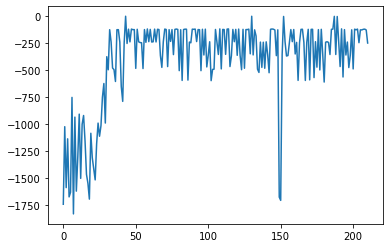

In [6]:
def play_episode(env, agent, seed=None, mode=None, render=False):
    observation = env.reset(seed=seed)
    reward, termination, truncation = 0., False, False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, termination)
        if render:
            env.render()
        if termination or truncation:
            break
        observation, reward, termination, truncation, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env, agent, seed=episode,
            mode='train')
    episode_rewards.append(episode_reward)
    logging.info('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -150:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.info('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [7]:
env.close()